# **GIS × Python Tutorial Session11 ~ Rasterデータ処理 ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br><br><br>

 - 使用するRasterデータの作成
 - GDALでの出力と読み込み
 - rasterioでの出力と読み込み
 - 投影変換
 - リサンプリング
 - 切り抜き
 - データのマスク
 - データマスクの挙動



## GDALとrasterio

In [46]:
from rasterio import Affine
import os
from pprint import pprint
from typing import Iterable

import japanize_matplotlib
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from osgeo import gdal
import pyproj
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.warp
import shapely
from shapely.plotting import plot_polygon, plot_points
japanize_matplotlib.japanize()


IN_EPSG = 'EPSG:6678'
proj_crs = pyproj.CRS(IN_EPSG)
IN_SRS = proj_crs.to_wkt(pretty=True)

## Rasterデータの作成
---

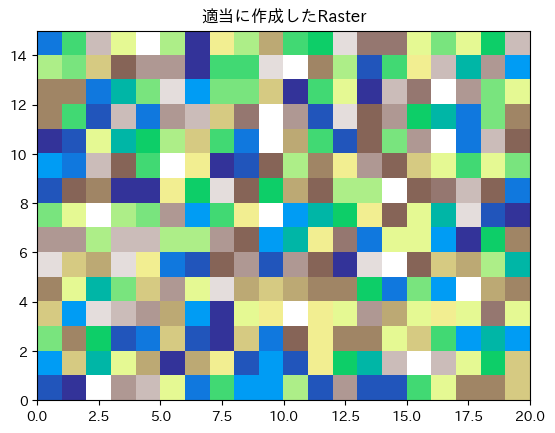

In [2]:
cols = 20
rows = 15
image = np.array([np.random.randint(0, 20, cols) for i in range(rows)])

extent = (0, cols, 0, rows)
fig, ax = plt.subplots()
ax.set_title('適当に作成したRaster')
ax.imshow(image, extent=extent, cmap='terrain');

## GDALを使用したRasterの出力
---

In [3]:
# ファイルパス
RASTER_FILE_GDAL = r'../datasets/session11/RASTER_GDAL.tif'

# メタデータの準備
meta_data = dict(
    xsize=cols,
    ysize=rows,
    bands=1,
    eType=gdal.GDT_Byte
)

# 書き込み準備
driver_gtiff = gdal.GetDriverByName('GTiff')
gdal_dst = driver_gtiff.Create(RASTER_FILE_GDAL, **meta_data)

# 空間参照系の定義
gdal_dst.SetProjection(IN_SRS)

# 座標やセルサイズの定義
# [X_Min, セルの幅, 行回転, Y_Max, 列回転, セルの高さ]
transform = [0, 1, 0, rows, 0, -1]
gdal_dst.SetGeoTransform(transform)

# Rasterの書き込み
gdal_dst.GetRasterBand(1).WriteArray(image)
gdal_dst.GetRasterBand(1).SetNoDataValue(-9999)
gdal_dst.FlushCache()
gdal_dst.Close()

d:\jlab\envs\lidar\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


0

## GDALを使用したRasterの読み込み
---

In [4]:
gdal_dst = gdal.Open(RASTER_FILE_GDAL)
gdal_ary = gdal_dst.ReadAsArray(0)


print(f"""< GDAL >
Projection: {gdal_dst.GetProjection()}
Transform: {gdal_dst.GetGeoTransform()}
Bands: {gdal_dst.RasterCount}
Array shape: {gdal_ary.shape}
""")

< GDAL >
Projection: PROJCS["JGD2011 / Japan Plane Rectangular CS X",GEOGCS["JGD2011",DATUM["Japanese_Geodetic_Datum_2011",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1128"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6668"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",140.833333333333],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","6678"]]
Transform: (0.0, 1.0, 0.0, 15.0, 0.0, -1.0)
Bands: 1
Array shape: (15, 20)



## rasterioを使用したRasterの出力と読み込み
---

In [5]:
# ファイルパス
RASTER_FILE_RIO = r'../datasets/session11/RASTER_RIO.tif'

# メタデータの準備
meta_data = dict(
    driver='GTiff',
    dtype='uint8',
    count=1,
    height=rows,
    width=cols,
    crs=IN_SRS,
    # gdal: [左上のX座標, セルの幅, 行回転, 左上のY座標, 列回転, セルの高さ]
    # rasterio: [セル幅, 行回転, X_Min, 列回転, セルの高さ, Y_Max]
    transform=Affine(1, 0, 0, 0, -1, rows)
)

# Rasterの書き込み
with rasterio.open(RASTER_FILE_RIO, mode='w', **meta_data) as rio_dst:
    rio_dst.write(image, 1)


## rasterioを使用したRasterの読み込み
---

In [6]:
rio_dst = rasterio.open(RASTER_FILE_RIO)
rio_ary = rio_dst.read(1)

print(f"""< rasterio >
Projection: {rio_dst.read_crs().to_wkt()}
Transform: 
{rio_dst.transform}
Bands: {rio_dst.indexes}
Array shape: {rio_ary.shape}
""")


< rasterio >
Projection: PROJCS["JGD2011 / Japan Plane Rectangular CS X",GEOGCS["JGD2011",DATUM["Japanese_Geodetic_Datum_2011",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1128"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6668"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",140.833333333333],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","6678"]]
Transform: 
| 1.00, 0.00, 0.00|
| 0.00,-1.00, 15.00|
| 0.00, 0.00, 1.00|
Bands: (1,)
Array shape: (15, 20)



## 投影変換
---

### GDAL の場合
Rasterの投影変換の場合は注意が必要です。まずは入力SRSと出力SRSだけを指定して投影変換してみます。

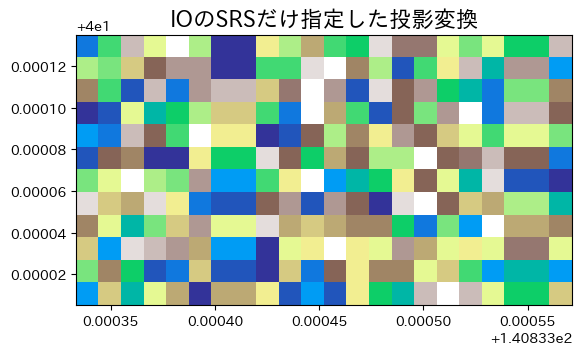

In [33]:
REPROJ_FILE_GDAL = RASTER_FILE_GDAL.replace('GDAL', 'GDAL_REPROJECTED')

_dst = gdal.Warp(
    destNameOrDestDS=REPROJ_FILE_GDAL, 
    srcDSOrSrcDSTab=RASTER_FILE_GDAL, 
    srcSRS=pyproj.CRS('EPSG:6678').to_wkt(),
    dstSRS=pyproj.CRS('EPSG:4326').to_wkt()
)
_dst.Close()
_dst = None

# 可視化してみる
with rasterio.open(REPROJ_FILE_GDAL, mode='r') as _dst:
    fig, ax = plt.subplots()
    ax.set_title('IOのSRSだけ指定した投影変換', fontsize=16)
    rasterio.plot.show(_dst, cmap='terrain', ax=ax)

上記の可視化したRasterを見てください。

一部横長になってしまっている列が確認できます。

範囲を指定して投影変換してみましょう。

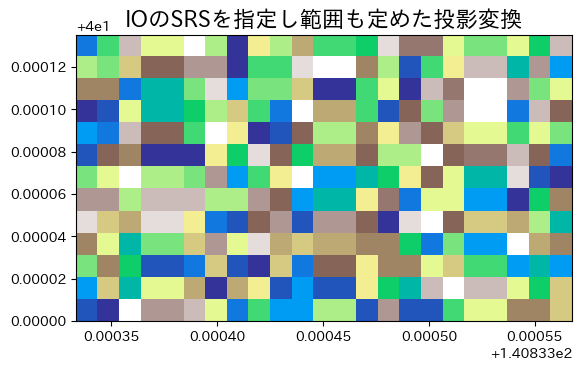

In [36]:
def reprod_bounds(gdal_dst, in_epsg, out_epsg):
    # 投影変換後の四隅の座標を計算
    transform = gdal_dst.GetGeoTransform()
    x_min = transform[0]
    y_max = transform[3]
    rows, cols = gdal_dst.ReadAsArray(0).shape
    x_resol = transform[1]
    y_resol = transform[-1]
    x_max = x_min + cols * x_resol
    y_min = y_max + rows * y_resol
    transformer = (
        pyproj
        .Transformer
        .from_crs(
            crs_from=f'EPSG:{in_epsg}', 
            crs_to=f'EPSG:{out_epsg}',
            always_xy=True
        )
    )
    xx, yy = transformer.transform([x_min, x_max], [y_min, y_max])
    # (X_min, Y_min, X_max, Y_max)
    return (xx[0], yy[0], xx[1], yy[1])




_dst = gdal.Warp(
    destNameOrDestDS=REPROJ_FILE_GDAL, 
    srcDSOrSrcDSTab=RASTER_FILE_GDAL, 
    # 投影変換後の範囲を計算
    outputBounds=reprod_bounds(gdal_dst, 6678, 4326),
    srcSRS=pyproj.CRS('EPSG:6678').to_wkt(),
    dstSRS=pyproj.CRS('EPSG:4326').to_wkt(),
)
_dst.Close()
_dst = None


# 可視化してみる
with rasterio.open(REPROJ_FILE_GDAL, mode='r') as _dst:
    fig, ax = plt.subplots()
    ax.set_title('IOのSRSを指定し範囲も定めた投影変換', fontsize=16)
    rasterio.plot.show(_dst, cmap='terrain', ax=ax)

範囲も指定しましたが、まだ横伸びしたセルがあります。

投影変換の際には詳細にオプションを指定する必要がありそうです。

以下では投影変換する為のオプションを作成する関数を定義しています。定義する項目は以下の通りです。


 - format = 出力ファイルフォーマット
 - outputBounds = 投影変換後の出力範囲
 - xRes = X解像度
 - yRes = Y解像度
 - width = 横方向のセル数
 - height = 縦方向のセル数
 - srcSRS = 入力SRS
 - dstSRS = 出力SRS

In [38]:
class GdalReprojWarpOption(object):
    # GDALで投影変換する為のオプションを作成する。
    def __init__(self, gdal_dataset: gdal.Dataset, in_epsg: int, out_epsg: int):
        self._dst = gdal_dataset
        self._in_epsg = in_epsg
        self._out_epsg = out_epsg
        self.bounds = self._reproj_bounds

    @property
    def _reproj_bounds(self):
        # 投影変換後の四隅の座標を計算
        transform = gdal_dst.GetGeoTransform()
        x_min = transform[0]
        y_max = transform[3]
        rows, cols = gdal_dst.ReadAsArray(0).shape
        x_resol = transform[1]
        y_resol = transform[-1]
        x_max = x_min + cols * x_resol
        y_min = y_max + rows * y_resol
        xx, yy = self._proj_transform([x_min, x_max], [y_min, y_max])
        return (xx[0], yy[0], xx[1], yy[1])

    def _proj_transform(self, 
        x: float | Iterable[float], 
        y: float | Iterable,
    ):
        # 座標の投影変換
        transformer = (
            pyproj
            .Transformer
            .from_crs(
                crs_from=self._get_srs(self._in_epsg), 
                crs_to=self._get_srs(self._out_epsg),
                always_xy=True
            )
        )
        xx, yy = transformer.transform(x, y)
        return xx, yy

    def _get_srs(self, epsg: int):
        proj_crs = pyproj.CRS(f"EPSG:{epsg}")
        return proj_crs.to_wkt()
    
    @property
    def _x_resolution(self):
        # X方向の解像度
        return abs((self.bounds[2] - self.bounds[0]) / self._dst.RasterXSize)
    
    @property
    def _y_resolution(self):
        # Y方向の解像度
        return abs((self.bounds[3] - self.bounds[1]) / self._dst.RasterYSize)




def repro_warp_options(
    gdal_dataset: gdal.Dataset, 
    in_epsg: int, 
    out_epsg: int
) -> gdal.WarpOptions:
    # GDALで投影変換する際に必要なオプションを作成する
    repro_options = GdalReprojWarpOption(gdal_dataset, in_epsg, out_epsg)
    options = dict(
        format='GTiff',
        outputBounds=repro_options.bounds,
        xRes=repro_options._x_resolution,
        yRes=repro_options._y_resolution,
        width=gdal_dataset.RasterXSize,
        height=gdal_dataset.RasterYSize,
        srcSRS=repro_options._get_srs(in_epsg),
        dstSRS=repro_options._get_srs(out_epsg)
    )
    return gdal.WarpOptions(**options)

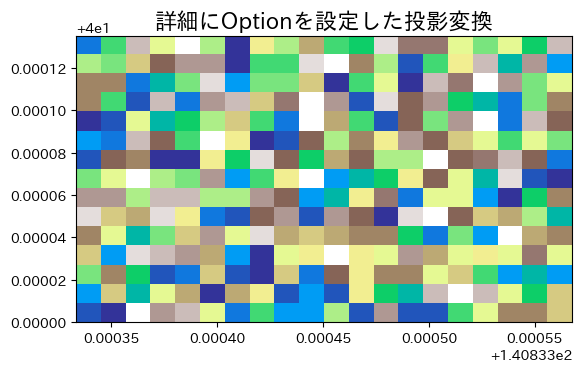

In [39]:
_dst = gdal.Warp(
    destNameOrDestDS=REPROJ_FILE_GDAL, 
    srcDSOrSrcDSTab=RASTER_FILE_GDAL, 
    options=repro_warp_options(gdal_dst, 6678, 4326)
)
_dst.Close()
_dst = None


# 可視化してみる
with rasterio.open(REPROJ_FILE_GDAL, mode='r') as _dst:
    fig, ax = plt.subplots()
    ax.set_title('詳細にOptionを設定した投影変換', fontsize=16)
    rasterio.plot.show(_dst, cmap='terrain', ax=ax)

### rasterioの場合

rasterioの場合はgdalよりも簡単です。アフィン変換行列を定義して、新たなSRSを渡せば綺麗に投影変換してくれます。

In [117]:
def rio_repro_metadata(dst, out_epsg: int, dtype: str='int16', nodata: int=-99):
    # transfromに渡すAffineオブジェクトを作成する
    # 入力Rasterの空間参照系
    in_srs = rio_dst.crs.to_wkt()
    # 出力Rasterの空間参照系
    out_srs = pyproj.CRS(f"EPSG:{out_epsg}").to_wkt()
    # 入力Rasterの範囲を取得して、投影変換する
    bounds = rio_dst.bounds
    transformer = (
        pyproj
        .Transformer
        .from_crs(
            crs_from=in_srs, 
            crs_to=out_srs,
            always_xy=True
        )
    )
    xx, yy = (
        transformer
        .transform(
            [bounds.left, bounds.right], 
            [bounds.bottom, bounds.top]
        )
    )
    # 解像度を計算
    x_resol = abs((xx[1] - xx[0]) / dst.width)
    y_resol = abs((yy[1] - yy[0]) / dst.height) * -1
    # アフィン変換行列を定義
    transform = Affine(x_resol, 0, xx[0], 0, y_resol, yy[1])
    meta_data = dict(
        driver='GTiff',
        width=dst.width,
        height=dst.height,
        count=dst.count,
        crs=out_srs,
        transform=transform,
        dtype=dtype,
        nodata=nodata
    )    
    return meta_data



# 出力Rasterのパス
REPROJ_FILE_RIO = RASTER_FILE_RIO.replace('RIO', 'RIO_REPROJECTED')
# 入力Rasterの読み込み
rio_dst = rasterio.open(RASTER_FILE_RIO)

meta_data = rio_repro_metadata(rio_dst, 4326)

with rasterio.open(REPROJ_FILE_RIO, mode='w', **meta_data) as new_dst:
    for count, ary in enumerate(rio_dst.read()):
        new_dst.write(ary, count + 1)

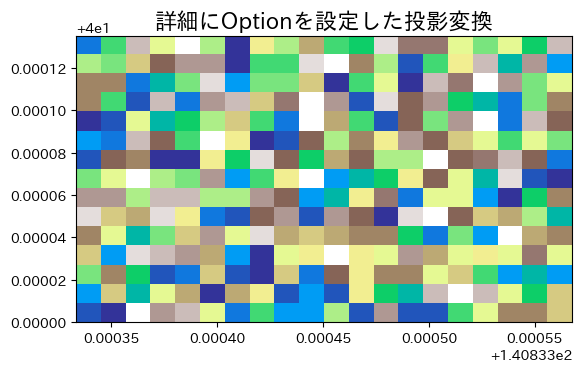

In [116]:
# 可視化してみる
with rasterio.open(REPROJ_FILE_RIO, mode='r') as _dst:
    fig, ax = plt.subplots()
    ax.set_title('詳細にOptionを設定した投影変換', fontsize=16)
    rasterio.plot.show(_dst, cmap='terrain', ax=ax)

In [106]:
def intersects(x: float, y: float, polygon: shapely.Polygon):
    pass

def within(x: float, y: float, polygon: shapely.Polygon):
    pass

def touches(x: float, y: float, polygon: shapely.Polygon):
    pass


def rasterize_poly(
    poly: shapely.Polygon, 
    gdal_dst: gdal.Dataset, 
    center=True
) -> np.ndarray[bool]:
    transform = gdal_dst.GetGeoTransform()
    # 四隅の座標を計算
    x_min = transform[0]
    y_max = transform[3]
    rows, cols = gdal_dst.ReadAsArray(0).shape
    x_resol = transform[1]
    y_resol = transform[-1]
    x_max = x_min + cols * x_resol
    y_min = y_max + rows * y_resol

    # X方向とY方向のセルの中心を計算
    x_lst = np.arange(x_min, x_max, abs(x_resol)) + abs(x_resol) / 2
    y_lst = np.arange(y_min, y_max, abs(y_resol)) + abs(y_resol) / 2
    base_raster = []
    for y in y_lst:
        base_line = []
        for x in x_lst:
            pt = shapely.Point(x, y)
            if poly.intersects(pt):
                base_line.append(True)
            else:
                base_line.append(False)
        base_raster.append(base_line)
    return np.array(base_raster)


mask = shapely.box(5, 2, 15, 13)
masked = rasterize_poly(mask, gdal_dst)

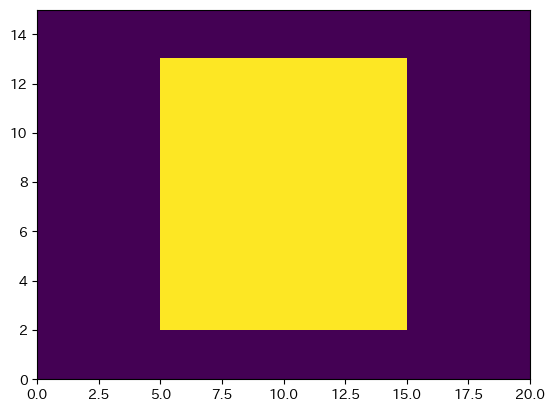

In [107]:
fig, ax = plt.subplots()
ax.imshow(masked, extent=extent)

計測対象範囲やマスク範囲の確認

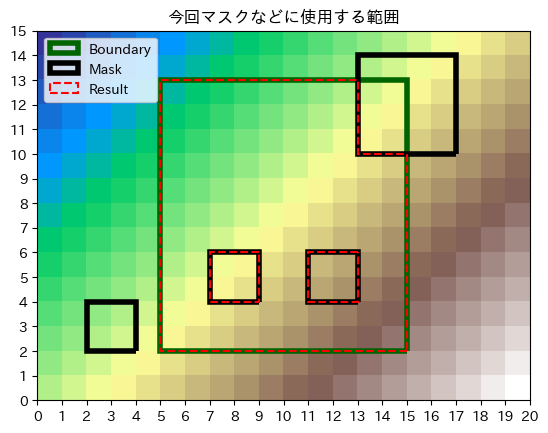

In [129]:
def plot_add_geometry(boundary, masks, ax):
    plot_polygon(boundary, facecolor=(0,0,0,0), color='darkgreen', lw=4,
                 add_points=False, ax=ax,
                 label=f"Boundary")
    
    kwargs = dict(color='black', facecolor=(0,0,0,0), 
                  lw=4, add_points=False, ax=ax)
    for i, mask in enumerate(masks):
        if i == 1:
            plot_polygon(mask, label=f"Mask", **kwargs)
        else:
            plot_polygon(mask, **kwargs)
    result = boundary.difference(shapely.MultiPolygon(masks))
    plot_polygon(result, ax=ax, add_points=False, color='red',
                 lw=1.5, ls='--', facecolor=(0,0,0,0), label=f"Result")
    return ax.get_legend_handles_labels()


boundary = shapely.box(5, 2, 15, 13)
masks = [
    shapely.box(*shapely.Point(3, 3).buffer(1).bounds),
    shapely.box(*shapely.Point(8, 5).buffer(1).bounds),
    shapely.box(*shapely.Point(12, 5).buffer(1).bounds),
    shapely.box(*shapely.Point(15, 12).buffer(2).bounds),
]

fig, ax = plt.subplots()
ax.set_title('今回マスクなどに使用する範囲')
ax.imshow(image, extent=extent, cmap='terrain');
plot_add_geometry(boundary, masks, ax)
ax.set_xticks(np.arange(0, cols + 1))
ax.set_yticks(np.arange(0, rows + 1))
ax.grid(False)
ax.legend();

In [132]:
dst = rio_dst

範囲の絞りこみ

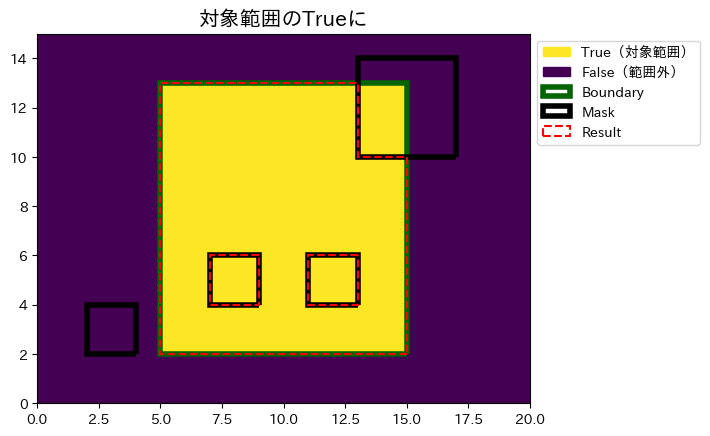

In [133]:
# 範囲の絞りこみ
scoped = (
    rasterio
        .mask
        .raster_geometry_mask(
            dataset=dst,  
            shapes=[boundary], 
            invert=True
        # 0番目に配列が格納されている
        )[0]
)

# colormapから最初と最後の値を取り出す
cmap = plt.colormaps.get_cmap('viridis')
true_color = cmap(255)
false_color = cmap(0)


# 可視化
fig, ax = plt.subplots()
ax.set_title('対象範囲のTrueに', fontsize=15)
ax.imshow(scoped, extent=extent, cmap='viridis')
hanbles_labels = plot_add_geometry(boundary, masks, ax)
patches = [
    matplotlib.patches.Patch(color=true_color, label="True（対象範囲）"),
    matplotlib.patches.Patch(color=false_color, label="False（範囲外）"),
] + hanbles_labels[0]
ax.legend(handles=patches, bbox_to_anchor=(1, 1))
plt.show()

マスク

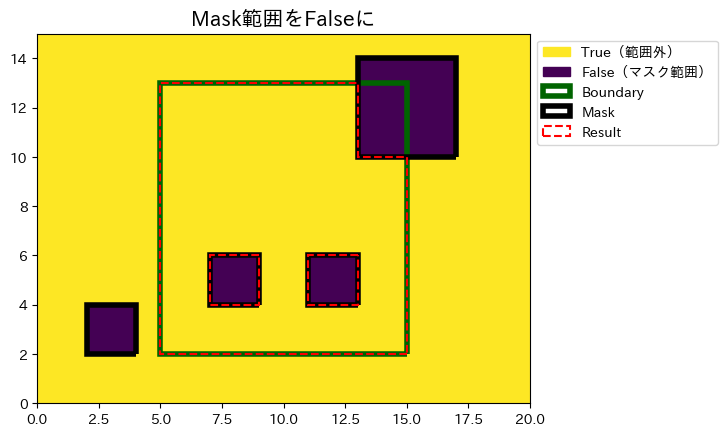

In [134]:
masked = (
    rasterio
        .mask
        .raster_geometry_mask(
            dataset=dst, 
            shapes=masks,
        )[0]
)

# 可視化
fig, ax = plt.subplots()
ax.set_title('Mask範囲をFalseに', fontsize=15)
ax.imshow(masked, extent=extent)
hanbles_labels = plot_add_geometry(boundary, masks, ax)
patches = [
    matplotlib.patches.Patch(color=true_color, label="True（範囲外）"),
    matplotlib.patches.Patch(color=false_color, label="False（マスク範囲）")
] + hanbles_labels[0]
ax.legend(handles=patches, bbox_to_anchor=(1, 1))
plt.show()

組み合わせ

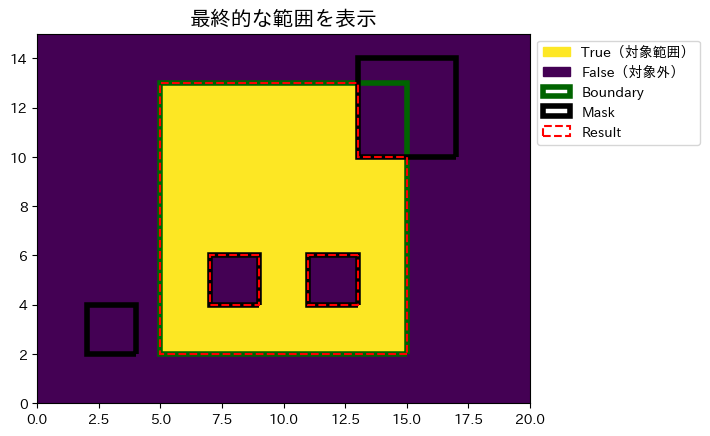

In [135]:
target = np.where(
    (scoped == True)
    & (masked == True),
    True,
    False
)

# 可視化
fig, ax = plt.subplots()
ax.set_title('最終的な範囲を表示', fontsize=15)
ax.imshow(target, extent=extent)
hanbles_labels = plot_add_geometry(boundary, masks, ax)
patches = [
    matplotlib.patches.Patch(color=true_color, label="True（対象範囲）"),
    matplotlib.patches.Patch(color=false_color, label="False（対象外）")
] + hanbles_labels[0]
ax.legend(handles=patches, bbox_to_anchor=(1, 1))
plt.show()

In [136]:
raster = [
    np.where(target == True, _raster, 0)
    for _raster in dst.read()
]

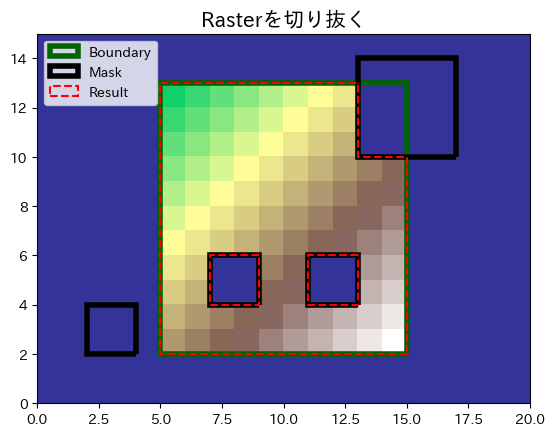

In [137]:
# 可視化
fig, ax = plt.subplots()
ax.set_title('Rasterを切り抜く', fontsize=15)
ax.imshow(np.dstack(raster), extent=extent, cmap='terrain')
plot_add_geometry(boundary, masks, ax)
plt.legend()
plt.show()

## rasterio mask の挙動

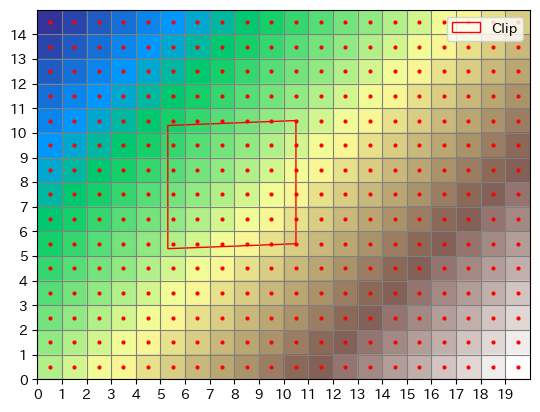

In [141]:
# 各セルの座標を取得
points = []
for x in range(dst.width):
    for y in range(dst.height):
        pt = shapely.Point(dst.xy(y, x))
        points.append(pt)

# 切り抜く範囲の作成
clip_poly = shapely.Polygon([[5.3, 5.3], [5.3, 10.3], 
                             [10.5, 10.5], [10.5, 5.5]])

fig, ax = plt.subplots()
ax.imshow(image, extent=extent, cmap='terrain')
plot_points(points, markersize=2, color='red')
plot_polygon(clip_poly, color='red', facecolor=(0,0,0,0), add_points=False, 
             label='Clip', ax=ax)
ax.set_xticks(np.arange(0, cols))
ax.set_yticks(np.arange(0, rows))
ax.grid(True, color='gray')
ax.legend();

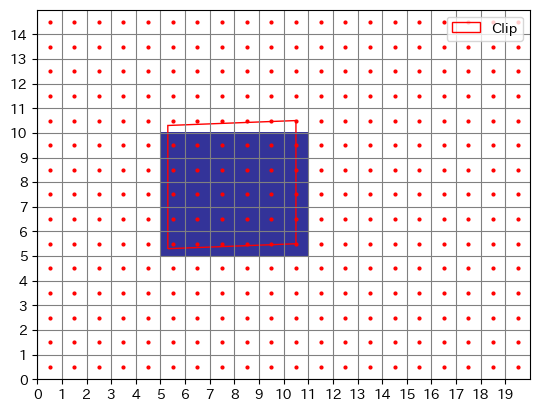

In [142]:
cliped_raster, _, _ = (
    rasterio
        .mask
        .raster_geometry_mask(
            dataset=dst, 
            shapes=[clip_poly],
        )
)

fig, ax = plt.subplots()
ax.imshow(cliped_raster, extent=extent, cmap='terrain')
plot_points(points, markersize=2, color='red')
plot_polygon(clip_poly, color='red', facecolor=(0,0,0,0), add_points=False, 
             label='Clip', ax=ax)
ax.set_xticks(np.arange(0, cols))
ax.set_yticks(np.arange(0, rows))
ax.grid(True, color='gray')
ax.legend();

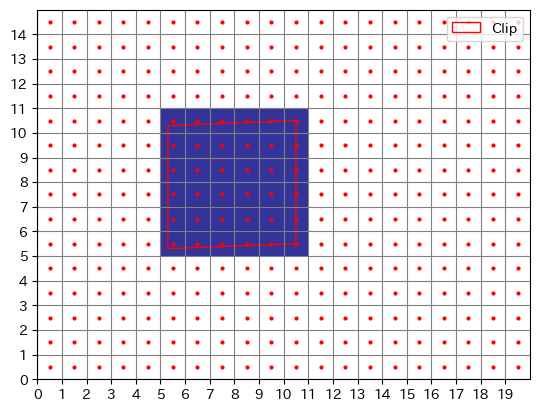

In [143]:
cliped_raster, _, _ = (
    rasterio
        .mask
        .raster_geometry_mask(
            dataset=dst, 
            shapes=[clip_poly],
            all_touched=True
        )
)

fig, ax = plt.subplots()
ax.imshow(cliped_raster, extent=extent, cmap='terrain')
plot_points(points, markersize=2, color='red')
plot_polygon(clip_poly, color='red', facecolor=(0,0,0,0), add_points=False, 
             label='Clip', ax=ax)

ax.set_xticks(np.arange(0, cols))
ax.set_yticks(np.arange(0, rows))
ax.grid(True, color='gray')
ax.legend();

rasterize

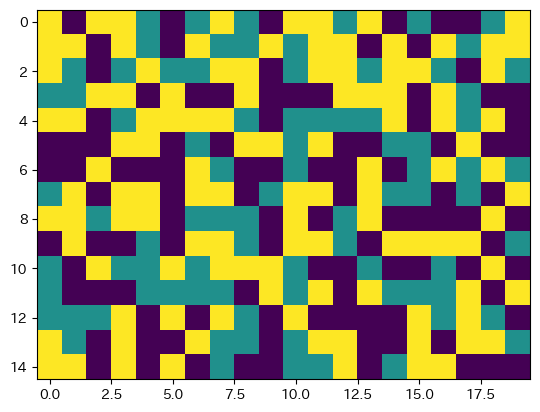

In [27]:
img = np.array([np.random.randint(0, 3, cols) for _ in range(rows)])
plt.imshow(img)

In [39]:
import rasterio.features


for dic in rasterio.features.shapes(img, transform=meta['transform']):
    # dic['coordinates']
    print(dic)

({'type': 'Polygon', 'coordinates': [[(1.0, 15.0), (1.0, 14.0), (2.0, 14.0), (2.0, 15.0), (1.0, 15.0)]]}, 0.0)
({'type': 'Polygon', 'coordinates': [[(6.0, 15.0), (6.0, 14.0), (7.0, 14.0), (7.0, 15.0), (6.0, 15.0)]]}, 1.0)
({'type': 'Polygon', 'coordinates': [[(7.0, 15.0), (7.0, 14.0), (8.0, 14.0), (8.0, 15.0), (7.0, 15.0)]]}, 2.0)
({'type': 'Polygon', 'coordinates': [[(9.0, 15.0), (9.0, 14.0), (10.0, 14.0), (10.0, 15.0), (9.0, 15.0)]]}, 0.0)
({'type': 'Polygon', 'coordinates': [[(12.0, 15.0), (12.0, 14.0), (13.0, 14.0), (13.0, 15.0), (12.0, 15.0)]]}, 1.0)
({'type': 'Polygon', 'coordinates': [[(13.0, 15.0), (13.0, 14.0), (14.0, 14.0), (14.0, 15.0), (13.0, 15.0)]]}, 2.0)
({'type': 'Polygon', 'coordinates': [[(14.0, 15.0), (14.0, 14.0), (15.0, 14.0), (15.0, 15.0), (14.0, 15.0)]]}, 0.0)
({'type': 'Polygon', 'coordinates': [[(15.0, 15.0), (15.0, 14.0), (16.0, 14.0), (16.0, 15.0), (15.0, 15.0)]]}, 1.0)
({'type': 'Polygon', 'coordinates': [[(16.0, 15.0), (16.0, 14.0), (18.0, 14.0), (18.0, 15.

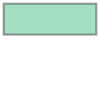

In [46]:
shapely.MultiPolygon([])

In [48]:
dic[0]['coordinates'][0]

[(17.0, 1.0), (17.0, 0.0), (20.0, 0.0), (20.0, 1.0), (17.0, 1.0)]